In [2]:
%run __init__.py
%load_ext autoreload
%autoreload 2

# First/second distance distribution

In [80]:
# log_path = "/home/konstantin/personal/Summertime/Net/runs/NetVGG_v6/4_emms=40.04919_analysis_log.csv"
# log_path = "/home/konstantin/personal/Summertime/Net/runs/NetVGG_v9/5_emms=62.12153_analysis_log.csv"

# log_path = "/home/konstantin/personal/Summertime/Net/runs/NetVGG_v21/9_emms=63.96605_analysis_log.csv"

log_path = "/home/konstantin/personal/Summertime/Net/runs/NetVGG_v5/5_emms=42.29398_analysis_log.csv"

log = pd.read_csv(log_path, index_col=[0])

In [81]:
log

,pos_desc_dist,neg_desc_dist,pos_desc_dist2,neg_desc_dist2,pos_num,vis_num
0,0.222115,0.297321,0.281596,0.338866,724,2103
1,0.357653,0.419745,0.413577,0.450911,273,1464
2,0.244723,0.287701,0.305472,0.330911,548,1390
3,0.309417,0.370599,0.372383,0.406908,476,1565
4,0.357740,0.450600,0.417199,0.479723,228,1209
...,...,...,...,...,...,...
5179,0.360208,0.431463,0.427266,0.464944,228,1301
5180,0.186835,0.210092,0.257520,0.258980,724,1704
5181,0.194138,0.218179,0.264134,0.268253,626,1502
5182,0.211091,0.253130,0.279362,0.301073,658,1662


In [82]:
pos_dist_ratio = log['pos_desc_dist'] / log['pos_desc_dist2']
neg_dist_ratio = log['neg_desc_dist'] / log['neg_desc_dist2']

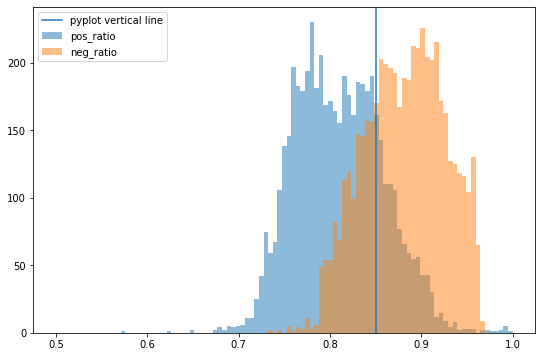

In [83]:
bins = np.linspace(0.5, 1, 100)

plt.figure(figsize=(9, 6))
plt.hist(pos_dist_ratio, bins, alpha=0.5, label='pos_ratio')
plt.hist(neg_dist_ratio, bins, alpha=0.5, label='neg_ratio')
plt.axvline(0.85, 0, 1, label='')
plt.legend(loc='upper left')
plt.show()

# Descriptor tests

In [2]:
config_path = '../configs/analyze.yaml'
namespace='Net.source.experiments.net'
gpu = '1'

mode = 'analyze'
dataset = 'megadepth'
model_name = 'NetVGG'
model_affix = 'v7'

experiment = create_experiment(config_path, namespace, gpu, mode, dataset, model_name, model_affix, '../')

model
	         grid_size : 8
	   descriptor_size : 64
	   nms_kernel_size : 15
	          detailed : True
	          use_disc : True
	        nms_thresh : 0.0
	        nms_k_size : 5
	             top_k : 512
	   checkpoint_name : ['6_emms=36.71007']
criterion
	        des_lambda : 1
	            margin : 1
	        det_lambda : 120
	      gauss_k_size : 15
	       gauss_sigma : 0.5
	         ep_lambda : 0.0008
dataset
	analyze
		megadepth
			      dataset_root : /home/konstantin/datasets/MegaDepthDataset
			   scene_info_root : /home/konstantin/datasets/MegaDepthDataset/SceneInfo
			          csv_path : /home/konstantin/datasets/MegaDepthDataset/SceneInfo/analyze_megadepth.csv
			            height : 480
			             width : 640
			           sources : True
loader
	analyze
		        batch_size : 3
		       num_samples : 3
		           shuffle : False
		       num_workers : 0
metric
	analyze
		         px_thresh : [1.0, 3.0, 5.0]
		         ep_thresh : 3.0
		      r_err_thresh : 2.

In [3]:
(batch, endpoint), metrics = experiment.run()

Model 6_emms=36.71007 is loaded


In [4]:
score1 = endpoint[f.SCORE1]
score2 = endpoint[f.SCORE2]

desc1 = endpoint[f.DESC1]
desc2 = endpoint[f.DESC2]

kp1 = endpoint[f.KP1]
kp2 = endpoint[f.KP2]

w_kp1 = endpoint[f.W_KP1]
w_kp2 = endpoint[f.W_KP2]

w_vis_kp1_mask = endpoint[f.W_VIS_KP1_MASK]
w_vis_kp2_mask = endpoint[f.W_VIS_KP2_MASK]

kp1_desc = endpoint[f.KP1_DESC]
kp2_desc = endpoint[f.KP2_DESC]

intrinsics1 = batch.get(d.INTRINSICS1)
intrinsics2 = batch.get(d.INTRINSICS2)

extrinsics1 = batch.get(d.EXTRINSICS1)
extrinsics2 = batch.get(d.EXTRINSICS2)

shift_scale1 = batch.get(d.SHIFT_SCALE1)
shift_scale2 = batch.get(d.SHIFT_SCALE2)

s_image1 = batch.get(d.S_IMAGE1)
s_image2 = batch.get(d.S_IMAGE2)

# Descriptor distance

In [5]:
from Net.source.nn.loss_utils import create_w_desc_grid, create_desc_coordinates_grid
from Net.source.utils.math_utils import calculate_distance_matrix
from Net.source.nn.forward_utils import flat2grid

In [6]:
grid_size = 8

w_desc_grid1, w_vis_desc_grid_mask1, \
        w_desc_grid2, w_vis_desc_grid_mask2 = create_w_desc_grid(score1, score2, desc1, desc2, batch, grid_size)

In [11]:
b, c, hc, wc = desc1.size()

# Create neigh mask
desc_grid2 = create_desc_coordinates_grid(desc2.shape, grid_size).view(b, -1, 2).to(desc2.device)
# Change orientation from x,y to y,x
desc_grid2 = desc_grid2[..., [1, 0]]

desc_grid_dist = calculate_distance_matrix(w_desc_grid1, desc_grid2)
_, lr = desc_grid_dist.min(dim=-1)

lr = lr.unsqueeze(-1)

ll = lr - 1
ll = torch.where(ll >= 0, ll, lr)

ur = lr - wc
ur = torch.where(ur >= 0, ur, lr)

ul = ur - 1
ul = torch.where(ul >= 0, ul, ur)

neigh_mask_ids = torch.cat([ul, ur, ll, lr], dim=-1)

neigh_mask = torch.zeros_like(desc_grid_dist).to(desc_grid_dist.device)
neigh_mask = neigh_mask.scatter(dim=-1, index=neigh_mask_ids, value=1)

In [12]:
cv_s_image1 = torch2cv(s_image1[0])
cv_s_image2 = torch2cv(s_image2[0])

In [23]:
cell_id = 705

# image1_cell = coo_grid1[0, cell_id].unsqueeze(0)
w_image1_cell = w_desc_grid1[0, cell_id].unsqueeze(0)

w_image1_cells = flat2grid(neigh_mask[0, cell_id].nonzero(), wc).squeeze(1) * grid_size + grid_size / 2

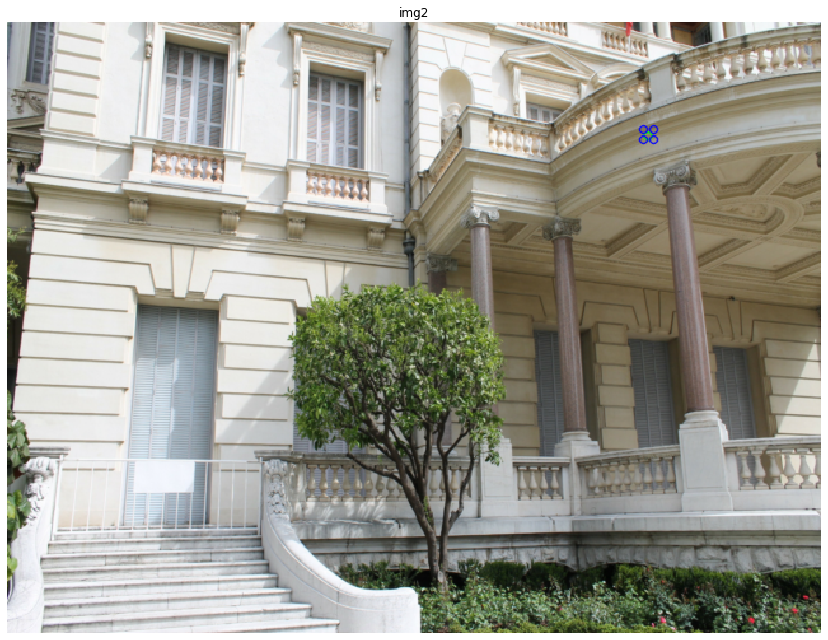

In [24]:
# res_image1 = draw_cv_keypoints(cv_s_image1, image1_cell, (0, 255, 0))

res_image2 = draw_cv_keypoints(cv_s_image2, w_image1_cell, (0, 255, 0))
res_image2 = draw_cv_keypoints(res_image2, w_image1_cells, (0, 0, 255))

plot_figures({'img2': res_image2}, 1, 1, (18, 9))

# Epipolar check

In [36]:
from Net.source.utils.math_utils import to_original
from Net.source.utils.matching_utils import select_kp, select_gt_matches

In [152]:
def check(kp1, w_kp1, kp2, w_kp2, w_vis_kp1_mask, w_vis_kp2_mask, \
          kp1_desc, kp2_desc, intrinsics1, intrinsics2, extrinsics1, extrinsics2,\
          shift_scale1, shift_scale2):
#     _, nn_desc_ids1 = get_mutual_desc_matches(kp2_desc, kp1_desc, DescriptorDistance.INV_COS_SIM, None)
    _, nn_desc_ids1 = get_mutual_desc_matches(kp1_desc, kp2_desc, DescriptorDistance.INV_COS_SIM, None)
    
    o_kp1 = to_original(kp1, shift_scale1)
    o_kp2 = to_original(kp2, shift_scale2)
    nn_o_kp2 = select_kp(o_kp2, nn_desc_ids1)

    F = compose_gt_fundamental(intrinsics1, intrinsics2, extrinsics1, extrinsics2)
    
    threshold_mask = select_gt_matches(nn_desc_ids1, kp1, w_kp1, kp2, w_kp2, w_vis_kp1_mask, w_vis_kp2_mask, torch.tensor([3.0]).to(kp1.device))

    ep_dist = epipolar_distance(o_kp1, nn_o_kp2, F)
    
    return ep_dist, threshold_mask

In [153]:
ep_dist1, threshold_mask1 = check(batch.split_r3(kp1), batch.split_r3(w_kp1),
          batch.split_r3(kp2), batch.split_r3(w_kp2),
          batch.split_r3(w_vis_kp1_mask), batch.split_r3(w_vis_kp2_mask),
          batch.split_r3(endpoint[f.KP1_DESC]), batch.split_r3(endpoint[f.KP2_DESC]),
          intrinsics1, intrinsics2, extrinsics1, extrinsics2,
          shift_scale1, shift_scale2)

In [154]:
idx = 0

In [164]:
ep_dist1[idx, threshold_mask1[0][idx]]

tensor([0.2626, 0.5800, 1.1591, 0.6743, 0.1547, 1.0164, 1.0060, 0.4907, 0.3243,
        1.6425, 0.1458, 0.6323, 0.3704, 0.0350, 0.2864, 1.6214, 0.5164, 0.5443,
        0.2786, 0.3749, 0.1989, 0.3749, 0.4480, 0.6117, 0.8278, 0.0225, 0.6623,
        1.7221, 1.0345, 0.0350, 3.3367, 0.1849, 0.2815, 0.8648, 0.0540, 0.7471,
        1.2765, 1.0121, 0.0558, 0.5024, 0.5921, 0.2703, 0.4612, 0.7459, 0.3530,
        0.8913, 0.0094, 0.2370, 1.4103, 6.4153, 0.8488, 0.5681, 0.4430, 0.2830,
        0.0682, 0.8306, 0.1033, 0.2915, 0.7935, 0.2680, 0.3377, 5.3937, 0.0495,
        1.1426], device='cuda:0')

In [161]:
ep_dist2, threshold_mask2 = check(batch.split_r3(kp2), batch.split_r3(w_kp2),
          batch.split_r3(kp1), batch.split_r3(w_kp1),
          batch.split_r3(w_vis_kp2_mask), batch.split_r3(w_vis_kp1_mask),
          batch.split_r3(endpoint[f.KP2_DESC]), batch.split_r3(endpoint[f.KP1_DESC]),
          intrinsics2, intrinsics1, extrinsics2, extrinsics1,
          shift_scale2, shift_scale1)

In [162]:
ep_dist2[idx, threshold_mask2[0][idx]]

tensor([1.1754, 5.3125, 0.8446, 0.9726, 0.2620, 0.4932, 0.5850, 0.5047, 3.4281,
        0.2687, 0.2896, 0.1577, 0.3806, 0.3713, 0.6263, 0.6812, 0.6558, 0.0681,
        1.0233, 0.5480, 0.0357, 0.4289, 0.1860, 1.0233, 0.8852, 0.1433, 0.5978,
        0.8302, 0.3767, 0.2360, 0.6191, 0.8055, 0.9492, 0.0357, 1.6284, 0.2653,
        0.1037, 0.6991, 0.2758, 0.2002, 0.0509, 1.5997, 0.4534, 0.0554, 1.4409,
        0.0210, 0.3406, 0.8211, 0.5457, 1.1771, 0.4686, 0.8571, 0.7524, 1.2749,
        0.2708, 0.7964, 0.2938, 0.0500, 1.5640, 6.6304, 0.2757, 0.5042],
       device='cuda:0')